In [3]:
import json

import matplotlib.pyplot as plt
from devtools import pprint
from sseclient import SSEClient as EventSource

class BColor:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m' # orange on some systems
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    LIGHT_GRAY = '\033[37m'
    DARK_GRAY = '\033[90m'
    BRIGHT_RED = '\033[91m'
    BRIGHT_GREEN = '\033[92m'
    BRIGHT_YELLOW = '\033[93m'
    BRIGHT_BLUE = '\033[94m'
    BRIGHT_MAGENTA = '\033[95m'
    BRIGHT_CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m' # called to return to standard terminal text color

In [4]:
def wiki_recentchange_stream():
    url = 'https://stream.wikimedia.org/v2/stream/recentchange'
    for event in EventSource(url):
        if event.event == 'message':
            try:
                change = json.loads(event.data)
            except ValueError:
                continue
            yield change
            
show_phantom = True
max_events = 1000
sampling_frac = 0.2 # Change before submitting
counter = 0
bot_counter = 0
for change in wiki_recentchange_stream():
    log_message = f"{change['user']} edited page {change['title']} in {change['wiki']}"
    if hash(str(change['title'])) % 100 < sampling_frac * 100:  # 20% sampling
        print(f"{counter+1}) {log_message}", end='')
        if change['bot'] is True:
            print(f"{BColor.BRIGHT_YELLOW} (bot){BColor.RESET}", end='')
            bot_counter += 1
        print()
        counter += 1
        if counter >= max_events:
            break
    else:
        if show_phantom:
            print(f"{BColor.DARK_GRAY}-) {log_message}{BColor.RESET}")

-) SchlurcherBot edited page File:Weera wickrama vibhushanaya.svg in commonswiki
1) KrBot edited page Q50963868 in wikidatawiki (bot)
-) Twofivesixbot edited page Q94844754 in wikidatawiki
-) EmausBot edited page Қатысушы талқылауы:ShteekWise in kkwiki
-) Loveless edited page Discussion utilisateur:Equidu94 in frwiki
-) KababyZMinsem edited page Q112512716 in wikidatawiki
-) 2A01:599:80E:716B:7EBF:C869:FF49:FC81 edited page Kaltenlengsfeld in dewiki
2) Spongy Is The Best edited page The Ren & Stimpy Show in itwiki
3) SchlurcherBot edited page File:1908 - Tocal College - C.B. Alexander Campus and Movable Collection - Alter and tapestry (movable item) by Margaret Grafton in chapel. (5061664b5).jpg in commonswiki (bot)
-) Stuartyeates edited page Q129251353 in wikidatawiki
4) Monkbot edited page Category:Pages using Lang-xx templates in enwiki (bot)
-) Martinevans123 edited page Jack Edward Oliver in enwiki
-) 2A02:26F7:E348:4000:44A3:D9D5:1243:8968 edited page Benutzer Diskussion:Cihanle

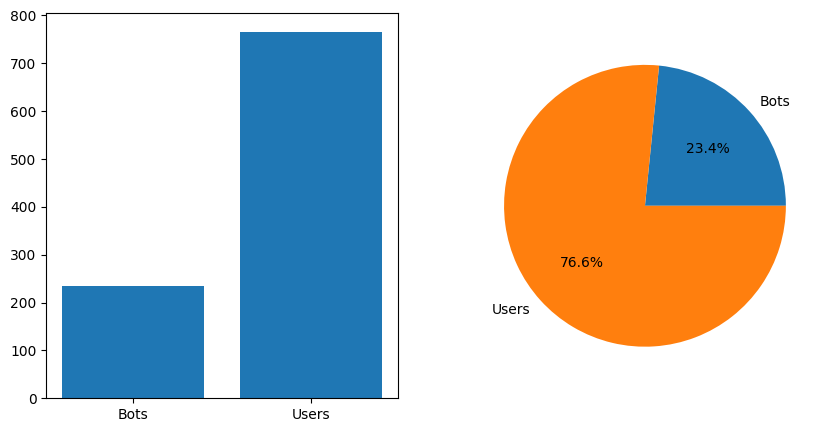

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Bots', 'Users'], [bot_counter, counter-bot_counter])
plt.subplot(1, 2, 2)
plt.pie([bot_counter, counter-bot_counter], labels=['Bots', 'Users'], autopct='%1.1f%%')
plt.show()

In [6]:
import math

class BloomFilter: # https://en.wikipedia.org/wiki/Bloom_filter
    def __init__(self, size: int = None, hash_count: int = None, capacity: int = None, false_positive_rate: float = None):
        # Ensure we have either (capacity, false_positive_rate) or (size, hash_count)
        if capacity is not None and false_positive_rate is not None and (size is None or hash_count is None):
            self.size = self._calculate_optimal_size(capacity, false_positive_rate)
            self.hash_count = self._calculate_optimal_hash_count(self.size, capacity)
            self.capacity = capacity
            self.false_positive_rate = false_positive_rate
        elif size is not None and hash_count is not None and (capacity is None or false_positive_rate is None):
            self.size = size
            self.hash_count = hash_count
            self.capacity = self._calculate_capacity(self.size, self.hash_count, false_positive_rate)
            self.false_positive_rate = self._calculate_false_positive_rate(self.size, self.hash_count, self.capacity)
        else:
            raise ValueError("Must provide either (capacity, false_positive_rate) or (size, hash_count)")

        self.bit_array = [0] * self.size
        self.inserted_count = 0

    @staticmethod
    def _calculate_optimal_size(capacity, false_positive_rate): #
        size = int(-capacity * math.log(false_positive_rate) / (math.log(2) ** 2))
        return max(1, size)

    @staticmethod
    def _calculate_optimal_hash_count(size, capacity):  # 
        hash_count = int((size / capacity) * math.log(2))
        return max(1, hash_count)
    
    @staticmethod
    def _calculate_capacity(size, hash_count, false_positive_rate):
        return int(-size * math.log(false_positive_rate) / (math.log(2) ** 2))
    
    @staticmethod
    def _calculate_false_positive_rate(size, hash_count, capacity):
        return (1 - math.exp(-hash_count * capacity / size)) ** hash_count

    def _get_hash_values(self, item):
        # Use two different hash functions
        hash1 = hash(str(item))
        hash2 = hash(str(item) + '0')
        
        for i in range(self.hash_count):
            # Kirsch-Mitzenmacher optimization: Use linear combination of two hash functions
            yield (hash1 + i * hash2) % self.size

    def add(self, item):
        if self.inserted_count >= self.capacity:
            print("Warning: Bloom filter is at capacity")
            
        for bit_index in self._get_hash_values(item):
            self.bit_array[bit_index] = 1
        self.inserted_count += 1

    def lookup(self, item):
        return all(self.bit_array[bit_index] == 1 for bit_index in self._get_hash_values(item))

    def reset(self):
        self.bit_array = [0] * self.size
        self.inserted_count = 0
        
    def __repr__(self):
        return (f'BloomFilter(size={self.size}, hash_count={self.hash_count}, '
                f'capacity={self.capacity}, false_positive_rate={self.false_positive_rate:.4f}, inserted_count={self.inserted_count})')
        
def test_bloom_filter_fpr(bf, test_size=100_000):
    for i in range(bf.capacity):
        bf.add(str(i))
    false_positives = sum(1 for i in range(bf.capacity, bf.capacity + test_size) 
                         if bf.lookup(str(i)))    
    actual_fpr = false_positives / test_size
    return actual_fpr

# Example usage
capacity = 100
target_fpr = 0.01
bf = BloomFilter(capacity=capacity, false_positive_rate=target_fpr)
actual_fpr = test_bloom_filter_fpr(bf)
bf.reset()

print(f"Bloom Filter parameters: {bf}")
print(f"Target FPR: {target_fpr:.6f}")
print(f"Actual FPR: {actual_fpr:.6f}")

Bloom Filter parameters: BloomFilter(size=958, hash_count=6, capacity=100, false_positive_rate=0.0100, inserted_count=0)
Target FPR: 0.010000
Actual FPR: 0.009800


In [8]:
bf.reset()
show_phantom = True
sampling_frac = 0.2 # Change before submitting
max_samples = 1000
#
counter = 0
bot_counter = 0
for change in wiki_recentchange_stream():
    log_message = f"{change.get('user', '')} ({'bot' if change['bot'] else 'user'}) edited page {change.get('title', '')} in {change.get('wiki', '')}"
    if hash(str(change['title'])) % 100 < sampling_frac * 100:
        if bf.lookup(change['user']): # Preicted Positive
            if change['bot']: # True Positive
                print(f"{BColor.BRIGHT_GREEN}{counter+1}) True Positive: {log_message}{BColor.RESET}", end='')
            else: # False Positive
                print(f"{BColor.BRIGHT_RED}{counter+1}) False Positive: {log_message}{BColor.RESET}", end='')
        elif change['bot'] is True: # True Negative
            print(f"{BColor.BRIGHT_YELLOW}{counter+1}) False Negative: {log_message}{BColor.RESET}")
            print(f"{BColor.BRIGHT_BLUE}Adding {change['user']} to the Bloom filter...{BColor.RESET}", end='')
            bf.add(change['user'])
            bot_counter += 1
        else:
            print(f"{counter+1}) {log_message}", end='')
        print()
        counter += 1
        if bot_counter >= bf.capacity or counter >= max_samples:
            break
    else:
        if show_phantom:
            print(f"{BColor.DARK_GRAY}-) {log_message}{BColor.RESET}")

-) SchlurcherBot (bot) edited page File:1908 Charles Varnum Massachusetts House of Representatives.png in commonswiki
-) Stuartyeates (user) edited page Q92751973 in wikidatawiki
-) SchlurcherBot (bot) edited page File:Palacio de Gobierno lateral 6.jpg in commonswiki
-) Slzbg (user) edited page Discussion:Crypsidromus in frwiki
-) Monkbot (bot) edited page Raj Ballav Koirala in enwiki
-) Crouch, Swale (user) edited page Category:Saint Peter's Church, Snailwell in commonswiki
-) Peter Ormond (user) edited page King's Flag for Australia in enwiki
-) Twofivesixbot (bot) edited page Q89558071 in wikidatawiki
1) Crouch, Swale (user) edited page Category:Snailwell in commonswiki
-) Ahmedou1980 (user) edited page طلوع الشمس من مغربها in arwiki
2) Velma (user) edited page Category:July 2022 in Kowloon City District in commonswiki
-) KababyZMinsem (user) edited page Q112518009 in wikidatawiki
-) Crouch, Swale (user) edited page Category:Saint Peter's Church, Snailwell in commonswiki
-) Velma (u